# Interpreting Hyperspectral Images with LIME: HYPERVIEW Challenge

This notebook demonstrates the usability of the Local Interpretable Model-agnostic Explanations (LIME) algorithm to interpret the predictions of a hyperspectral image regression model. The dataset used in this notebook is from the [HYPERVIEW Challenge](https://ai4eo.eu/challenge/hyperview-challenge/) organized by The European Space Agency (ESA). The goal of the challenge is to predict soil parameters based on the hyperspectral images of the ground.

The model used in this notebook is one of the top-performing models in the challenge. The trained model architecture is based on the Vision Transformer (ViT) and CLIP (Contrastive Language-Image Pretraining), and its fine-tuned weights are open-sourced under the Apache License in the [Hugging Face Model Hub](https://huggingface.co/KPLabs/HYPERVIEW-VisionTransformer). In the same place the original implementation of the CLIP model can be found. 

**Note**: Before running this notebook, make sure to install the required libraries used in the notebook, which are specified in the `requirements.txt` file. The `clip_model` module contains the code needed for additional preprocessing and model loading and can be downloaded from the [Vignettes in the `meteors` repository](https://github.com/xai4space/meteors/tree/main/examples/lime)



## Table of Contents
- [1. Loading the Model](#1.Loading-the-Model)
- [2. Loading the Hyperspectral data from HYPERVIEW Challenge](#2.Load-the-Hyperspectral-data-from-HYPERVIEW-Challenge)
- [3. Convert data into HSI image and preview the images](#3.Convert-data-into-HSI-image-and-preview-the-images)
- [4. Analyze HSI data with LIME](#4.Analyze-HSI-data-with-LIME)
  - [4.1. Spatial Analysis](#4.1.Spatial-Analysis)
  - [4.2. Spectral Analysis](#4.2.Spectral-Analysis)

In [215]:
import torch
import numpy as np
from tqdm import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd

import meteors as mt

from clip_model import build_model

torch.manual_seed(0)  # set seed for reproducibility


# print(mt.__name__, mt.__version__)

In [73]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1. Loading the Model

The dataset used for training this model can be found on the official page for the [HYPERVIEW Challenge](https://ai4eo.eu/challenge/hyperview-challenge/).

The following code snippet includes additional functions to load pre-trained CLIP weights and fine-tuned weights for the model.

In [74]:
import os
import hashlib
import urllib
import warnings


BASE_MODEL_URL = "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt"


def download(url: str, root: str, error_checksum: bool = True) -> str:
    os.makedirs(root, exist_ok=True)
    filename = os.path.basename(url)

    expected_sha256 = url.split("/")[-2]
    if expected_sha256 == "main":
        expected_sha256 = "0cc03ba20aff35a41312de47da843a0d8541acba3c2101d9691f3ab999128d34"  # CLIP sha256
    download_target = os.path.join(root, filename)
    print("INFO: Download Target: {}".format(download_target))

    if os.path.exists(download_target) and not os.path.isfile(download_target):
        raise RuntimeError(f"{download_target} exists and is not a regular file")

    if os.path.isfile(download_target):
        # real_sha256 = hashlib.sha256(open(download_target, "rb").read()).hexdigest()
        # print("INFO: Real SHA256: {}".format(real_sha256))
        # print("INFO: Expected SHA256: {}".format(expected_sha256))
        if hashlib.sha256(open(download_target, "rb").read()).hexdigest() == expected_sha256:
            return download_target
        else:
            warnings.warn(f"{download_target} exists, but the SHA256 checksum does not match; re-downloading the file")

    with urllib.request.urlopen(url) as source, open(download_target, "wb") as output:
        with tqdm(
            total=int(source.info().get("Content-Length")), ncols=80, unit="iB", unit_scale=True, unit_divisor=1024
        ) as loop:
            while True:
                buffer = source.read(8192)
                if not buffer:
                    break

                output.write(buffer)
                loop.update(len(buffer))

    if hashlib.sha256(open(download_target, "rb").read()).hexdigest() != expected_sha256:
        if error_checksum:
            raise RuntimeError("Model has been downloaded but the SHA256 checksum does not not match")
        else:
            warnings.warn("Model has been downloaded but the SHA256 checksum does not not match")

    return download_target


def load_base_clip(download_root: str, class_num: int = 1000):
    model_path = download(BASE_MODEL_URL, download_root)
    model = torch.jit.load(model_path, map_location="cpu").eval()
    model = build_model(model.state_dict(), downstream_task=4, class_num=class_num)
    model.float()
    return model

In [75]:
download_root = os.path.expanduser("~/.cache/clip")  # Change this to the directory where you want to download the model
num_classes = 4  # Number of classes in the original HYPERVIEW dataset

# Load the CLIP model with the HYPERVIEW head
model = load_base_clip(download_root=download_root, class_num=num_classes)

# Load the pre-trained weights
vit_checkpoint_path = download(
    "https://huggingface.co/KPLabs/HYPERVIEW-VisionTransformer/resolve/main/VisionTransformer.pt",
    download_root,
    error_checksum=False,
)
model.load_state_dict(torch.load(vit_checkpoint_path, map_location=device))
model.eval()
model = model.to(device)

INFO: Download Target: C:\Users\tymot/.cache/clip\ViT-L-14.pt
INFO: Download Target: C:\Users\tymot/.cache/clip\VisionTransformer.pt


C:\Users\tymot\AppData\Local\Temp\ipykernel_33844\1125051604.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(vit_checkpoint_path, map_l

## 2. Load the Hyperspectral data from HYPERVIEW Challenge

In this notebook, we will use the sample images from the HYPERVIEW Challenge dataset. The images are stored in the [tutorial repository]() in the `data` folder. The images are in the `.npy` format. The images are 3D hyperspectral images with 150 bands and various spatial dimensions. The images are stored in the raw format and with the mask applied while training the model.

First, we need to define the loading and preprocessing functions for the data.

In [76]:
def _shape_pad(data):
    max_edge = np.max(data.shape[1:])
    shape = (max_edge, max_edge)
    # padded = np.pad(data, ((0, 0), (0, (shape[0] - data.shape[1])), (0, (shape[1] - data.shape[2]))), "wrap")
    padded = np.pad(
        data,
        ((0, 0), (0, (shape[0] - data.shape[1])), (0, (shape[1] - data.shape[2]))),
        "constant",
        constant_values=0.0,
    )
    return padded


def load_single_npz_image(image_path):
    with np.load(image_path) as npz:
        data = npz["data"]
        mask = npz["mask"]

        mask = 1 - mask.astype(int)

        mask = _shape_pad(mask)
        data = _shape_pad(data)

        mask = mask.transpose((1, 2, 0))
        data = data.transpose((1, 2, 0))
        data = data / 5419

        return data, mask


def get_eval_transform(image_shape):
    return transforms.Compose(
        [
            transforms.Resize((image_shape, image_shape)),
        ]
    )

Now, let's load the hyperspectral image using functions we defined earlier.

In [77]:
data, mask = load_single_npz_image("data/0.npz")
masked_data = data * mask
masked_data = torch.from_numpy(masked_data.astype(np.float32)).permute(2, 0, 1)
eval_tr = get_eval_transform(224)

image_torch = eval_tr(masked_data)
not_masked_image_torch = eval_tr(torch.from_numpy(data.astype(np.float32)).permute(2, 0, 1))

print(f"Original data shape: {data.shape}")
print(f"Original mask shape: {mask.shape}")
print(f"Transformed data shape: {image_torch.shape}")

Original data shape: (89, 89, 150)
Original mask shape: (89, 89, 150)
Transformed data shape: torch.Size([150, 224, 224])


As we can see, the image is a 3D NumPy array with a shape transformed to (150, 224, 224), where 150 is the number of bands and 224x224 is the spatial dimension of the image. We will keep the image in both masked and unmasked formats.

Now, we need to specify the wavelengths of the bands in the image. The wavelengths were provided in the challenge dataset, but to avoid loading additional files, we save it as a simple pythonic list

In [209]:
wavelengths = [
    462.08,
    465.27,
    468.47,
    471.67,
    474.86,
    478.06,
    481.26,
    484.45,
    487.65,
    490.85,
    494.04,
    497.24,
    500.43,
    503.63,
    506.83,
    510.03,
    513.22,
    516.42,
    519.61,
    522.81,
    526.01,
    529.2,
    532.4,
    535.6,
    538.79,
    541.99,
    545.19,
    548.38,
    551.58,
    554.78,
    557.97,
    561.17,
    564.37,
    567.56,
    570.76,
    573.96,
    577.15,
    580.35,
    583.55,
    586.74,
    589.94,
    593.14,
    596.33,
    599.53,
    602.73,
    605.92,
    609.12,
    612.32,
    615.51,
    618.71,
    621.91,
    625.1,
    628.3,
    631.5,
    634.69,
    637.89,
    641.09,
    644.28,
    647.48,
    650.67,
    653.87,
    657.07,
    660.27,
    663.46,
    666.66,
    669.85,
    673.05,
    676.25,
    679.45,
    682.64,
    685.84,
    689.03,
    692.23,
    695.43,
    698.62,
    701.82,
    705.02,
    708.21,
    711.41,
    714.61,
    717.8,
    721.0,
    724.2,
    727.39,
    730.59,
    733.79,
    736.98,
    740.18,
    743.38,
    746.57,
    749.77,
    752.97,
    756.16,
    759.36,
    762.56,
    765.75,
    768.95,
    772.15,
    775.34,
    778.54,
    781.74,
    784.93,
    788.13,
    791.33,
    794.52,
    797.72,
    800.92,
    804.11,
    807.31,
    810.51,
    813.7,
    816.9,
    820.1,
    823.29,
    826.49,
    829.68,
    832.88,
    836.08,
    839.28,
    842.47,
    845.67,
    848.86,
    852.06,
    855.26,
    858.46,
    861.65,
    864.85,
    868.04,
    871.24,
    874.44,
    877.63,
    880.83,
    884.03,
    887.22,
    890.42,
    893.62,
    896.81,
    900.01,
    903.21,
    906.4,
    909.6,
    912.8,
    915.99,
    919.19,
    922.39,
    925.58,
    928.78,
    931.98,
    935.17,
    938.37,
]

## 3. Convert Data into HSI Image and Preview the Images
Now, having the raw data - the tensor representing the image, its wavelengths and the image orientation, we can to combine this information into a complete hyperspectral image. To create the hyperspectral image, we will use the `HSI` data class from the `meteors` package.

The `HSI` (HyperSpectral Image) class takes the hyperspectral image data, the wavelength data, and the orientation of the image as input and creates the meaningful hyperspectral image, that can be easily analysed in any downstream task.

Additionally, we may provide the binary mask, which may cover data irrelevant for the task. In our case we cover the regions where there is land whose parameters we do not want to estimate, for instance some forests, roads or rivers. If we learned the model on such unmasked data, it could faslely underestimate the predictions, since the measured soil parameters in such uncultivated land is usually lower.

In [55]:
# Create a binary mask from the image, where 1 is the masked region and 0 is the unmasked region
binary_mask = (image_torch > 0.0).int()

hsi_0 = mt.HSI(
    image=not_masked_image_torch,  # The preprocessed image saved as tensor/numpy ndarray
    wavelengths=wavelengths,  # The wavelengths list of the hyperspectral image
    orientation="CWH",  # The orientation of the image tensor, here it is CWH (Channels, Width, Height)
    binary_mask=binary_mask,  # The binary mask tensor/numpy
    device=device,  # The device where the image data will be stored. We can provide it later with the .to(device) method
)

2024-09-18 21:28:22.442 | DEBUG    | meteors.hsi:resolve_inference_device:112 - Device for inference: cpu


Now, let's view the hyperspectral image along with the masked and unmasked versions.

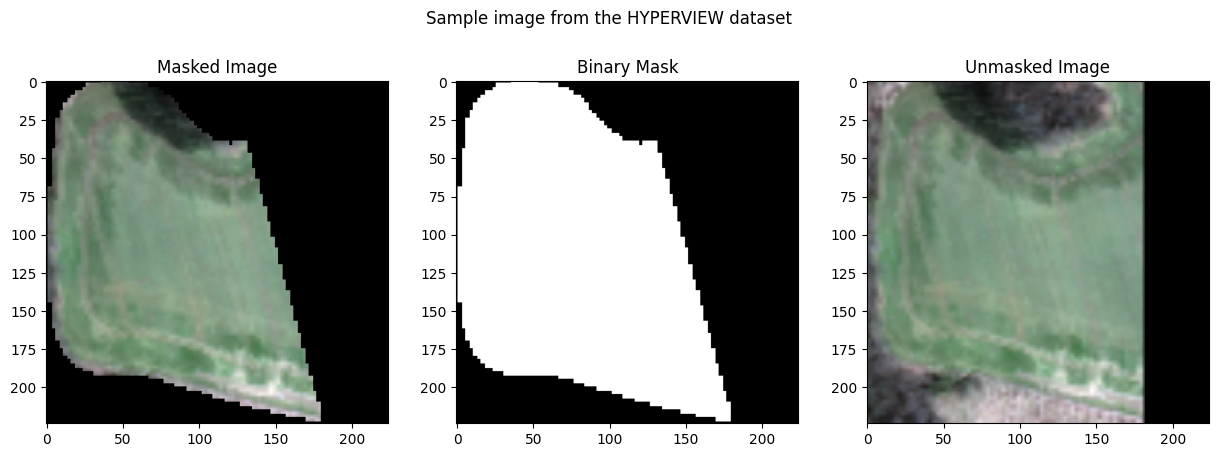

In [81]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

mt.visualize.lime_visualize.visualize_hsi(hsi_0, ax1, use_mask=True)
ax1.set_title("Masked Image")

ax2.imshow(binary_mask[0, ...].T.cpu().numpy(), cmap="gray")
ax2.set_title("Binary Mask")

mt.visualize.lime_visualize.visualize_hsi(hsi_0, ax3, use_mask=False)
ax3.set_title("Unmasked Image")

fig.suptitle("Sample image from the HYPERVIEW dataset")
plt.show()

The `HSI` dataclass automatically provides us the clean RGB chart of the hyperspectral image and releases us from the obligation of selecting the specific wavelengths to be plotted and considering the image orientation.

Now, we can provide the hyperspectral image to the model and get the prediction. The model will return the predictions for the 4 classes of the hyperspectral image.

In [80]:
original_prediction = model(not_masked_image_torch.unsqueeze(0))  # original image
hsi_prediction = model(hsi_0.image.unsqueeze(0))  # Hsi image
assert torch.allclose(original_prediction, hsi_prediction, atol=1e-3)

prediction_dict = {0: "Phosphorus", 1: "Potassium", 2: "Magnesium", 3: "pH"}  # The classes of the HYPERVIEW dataset

predictions = {prediction_dict[i]: float(hsi_prediction[0, i].cpu().detach().numpy()) for i in range(4)}
predictions = pd.Series(predictions)
predictions

Phosphorus    0.210551
Potassium     0.350670
Magnesium     0.391935
pH            0.883228
dtype: float64

## 4. Analyze HSI Data with LIME
[LIME]((https://dl.acm.org/doi/abs/10.1145/2939672.2939778)) (Local Interpretable Model-agnostic Explanations) is a model-agnostic algorithm that explains the predictions of a model by approximating the model's decision boundary around the prediction. The algorithm generates a set of perturbed samples around the input sample and fits a linear model to the predictions of the perturbed samples. The linear model is then used to explain the prediction of the input sample.

To initialize the LIME object, we need to provide the following parameters:
- `explainable_model`: The model to be explained, used to predict the hyperspectral image and the task type. In order to integrate any model with our methods, the model has to be wrapped in a class from the meteors package, providing additional info for the LIME explainer, such as the problem type.
- `interpretable_model`: The model used to approximate the decision boundary of the model. It could be any kind of easily interpretable model. The package provides implementations of Ridge and Lasso linear models ported from `sklearn` library and in this notebook we use a Lasso regression model. 


Meteors package supports explaining the model solving 3 different machine learning problems:
- regression
- classification
- segmentation

Since the linear, interpretable models used in the package for creating the LIME explanations do not solve directly the segmentation problem, we apply a handy trick that converts this problem into a regression problem that can be solved by linear models. This idea is inspired from the `captum` library and involves appropriately counting pixels in the segmentation mask so that the number of pixels in each segment can be estimated by the regression model.


Let's initialize the LIME explainer with the CLIP model!

In [58]:
explainable_model = mt.utils.models.ExplainableModel(model, "regression")  # The model to be explained
interpretable_model = mt.utils.models.SkLearnLasso(
    alpha=0.001
)  # The interpretable model with regularization strength of 0.001

lime = mt.Lime(explainable_model, interpretable_model)  # The LIME explainer

## 4. Analyze HSI data with LIME
Our implementation of LIME explainer enables to analyze HSI data based on the spatial or spectral dimension. It allows to investigate which regions or which spectral bands are the most relevant for the model. The rest of the notebook will be divided into spectral and spatial analysis of HSI data.

### 4.1. Spatial Analysis
Similar to the original implementation of LIME for images, we will create spatial superpixels which are perturbed and used to train a surrogate model for explaining. These explanations will produce a correlation map with the output for each superpixel.
First, we need to prepare the segmentation mask. Essentially, the segmentation mask is a torch tensor or numpy ndarray that contains information to which superpixel (region) does the specified pixel belongs. Integer values in such tensor represent the labels of superpixels. The mask should have the same shape as the image, but should be repeated along the channels dimension. The package now supports three methods to create the mask:
- Using [SLIC](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_segmentations.html) for superpixel detection
- Using patch segmentation. Knowing that ViT uses squared non-overlapping sliding windows, we can also make superpixels based on the same technique
- Providing a custom mask

In this notebook we will present, how can we utilize different segmentation masks to investigate the model's performance and explore interesting areas in the images

In [82]:
segmentation_mask_slic = lime.get_segmentation_mask(hsi_0, segmentation_method="slic")
segmentation_mask_patch = lime.get_segmentation_mask(hsi_0, segmentation_method="patch", patch_size=14)

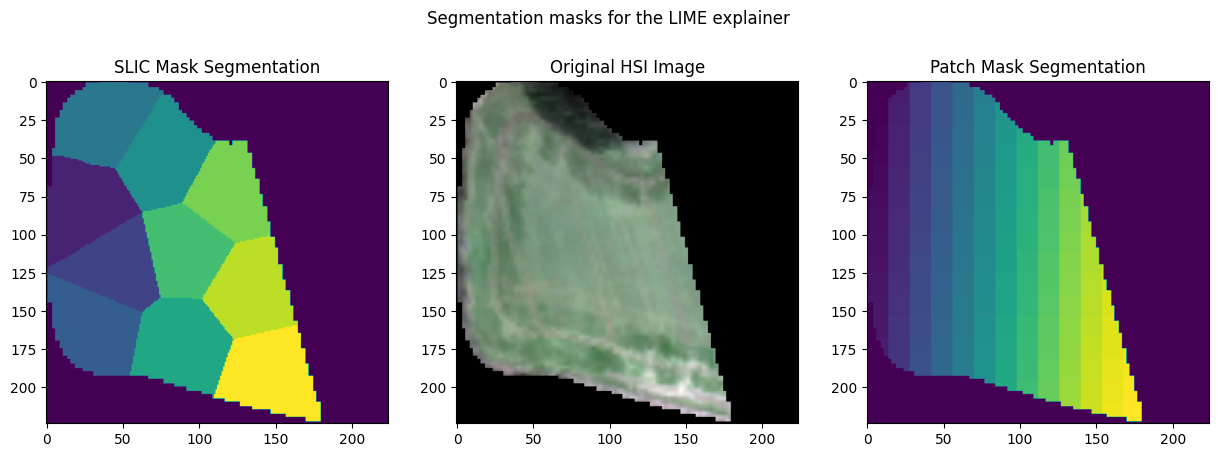

In [112]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(segmentation_mask_slic[0, ...].T)
ax1.set_title("SLIC Mask Segmentation")

mt.visualize.lime_visualize.visualize_hsi(hsi_0, ax2, use_mask=True)
ax2.set_title("Original HSI Image")

ax3.imshow(segmentation_mask_patch[0, ...].T)
ax3.set_title("Patch Mask Segmentation")

fig.suptitle("Segmentation masks for the LIME explainer")

plt.show()

Now, since we have our HSI sample data, segmentation mask and LIME model prepared, we will produce attribution maps for the segments. To do this, we simply need to execute one method `get_spatial_attributes`, and provide the HSI data, segmentation mask, and target class to be analyzed. If our model predicts more than one class (the model's output is multidimensional), we need to specify which target class we want to analyze. For each class, the analysis of the correlation with segments can be different.

In [92]:
spatial_attributes = lime.get_spatial_attributes(
    hsi_0,  # HSI data
    segmentation_mask_slic,  # Segmentation mask
    target=1,  # class analyzed: K - potassium
    n_samples=10,  # Number of perturbation, the more the better explainer is trained but the analsys is slower
    perturbations_per_eval=4,  # Number of perturbations evaluated at once
    verbose=True,  # If True, the function will print the progress
)

Lime attribution: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]
2024-09-18 22:57:40.924 | DEBUG    | meteors.lime:resolve_inference_device:459 - Device for inference: cpu


method `get_spatial_attributes` apart from the 3 required fields, takes as well few optional hyperparameters of explanations. Those are:
- `n_samples` - it is a number of the generated artificial samples on which the linear model is trained. The larger number of samples, the explanations produced by the linear model are usually better, since its predictions should better mimic the predictions of the explained model. However, the larger `n_samples` the longer attribution takes to be performed
- `perturbations_per_eval` - an inner batch size, this parameter may fasten the attribution, depending your machine capacity
- `verbose` - a parameter specifying whether to output a progress bar, that makes the waiting time for attribution more pleasant

The method has also an option to generate the segmentaion mask by itself, utilizing the static method `get_segmentation_mask` method under the hood.

More information about the `get_spatial_attributes` function can be found in its [reference page](https://xai4space.github.io/meteors/latest/reference/#src.meteors.attr.Lime.get_spatial_attributes) on the documentation website.


The obtained `spatial_attributes` object is an object containing all the necessary data about the explanation. It consists of few fields:
- `hsi` - a HyperSpectral Image object, 
- `mask` - here used for creation superpixels 
- `attributes` - explanations produced by the explainer of the same shape as the HSI
- `score` - R2 score of the linear model used for the attribution

Now, let us see how the attributions look like! 

Using the visualization capabilities provided by the `meteors` package, it is incredibely easy.

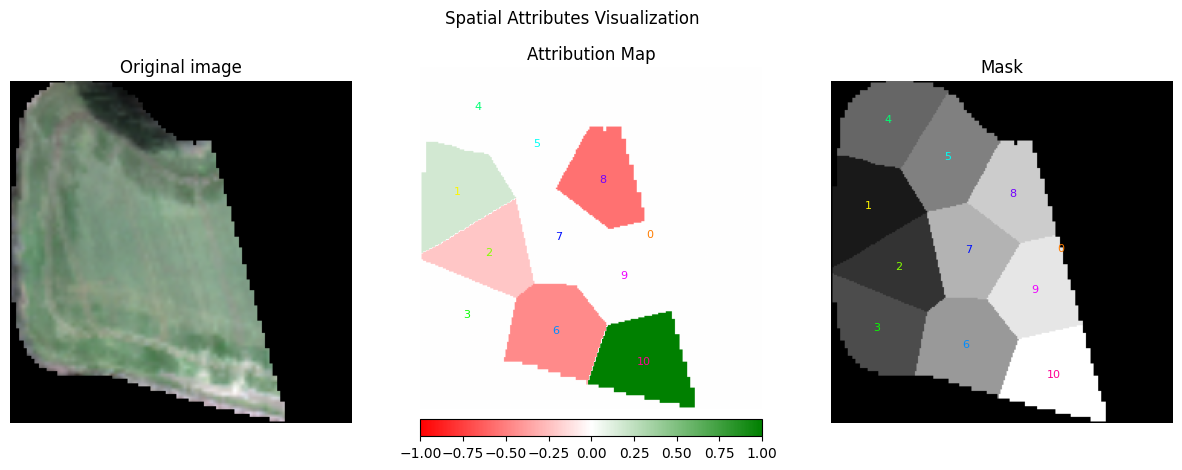

In [91]:
mt.visualize.visualize_spatial_attributes(spatial_attributes)
plt.show()

The plot presents three components (from the left)
1. On the left, the original image provided to LIME.
2. In the middle, the attribution map for each segment.
3. On the right, the segmented mask with IDs of the segments. The number 0 represents the masked region, and because it surrounds each segment, the placement of the number is in the middle of the segment.

The colors in the attribution map have the following meanings:
- **Red**: This superpixel is negatively correlated with the input. In our case, it means that the presence of this superpixel contributed to lowering the value for the target class 1.
- **White**: This segment did not have a significant impact on the output.
- **Green**: This superpixel is positively correlated with the output. Its presence increases the value for the class `1`.

To validate how well the surrogate model was trained, we also provide the `score` attribute, which indicates the `R2` metric (coefficient of determination) that measures how well the surrogate model was trained.

In [35]:
spatial_attributes.score

0.9498704075813293

High R2 score for the surrogate model hints that the attributions are sensible. In case the R2 score were very low, it could mean that the surrogate linear model can't tell which regions are more important for the explainable model preditions.

Let's analyze the attribution maps for class `0` representing phosphorus estimation. We can simply modify the `target` parameter, utilizing the same segmentation mask, and rerun the explanation process.

In [93]:
spatial_attributes = lime.get_spatial_attributes(hsi_0, segmentation_mask_slic, target=0, n_samples=10)

2024-09-18 22:58:14.126 | DEBUG    | meteors.lime:resolve_inference_device:459 - Device for inference: cpu


R2 metric: 0.6405


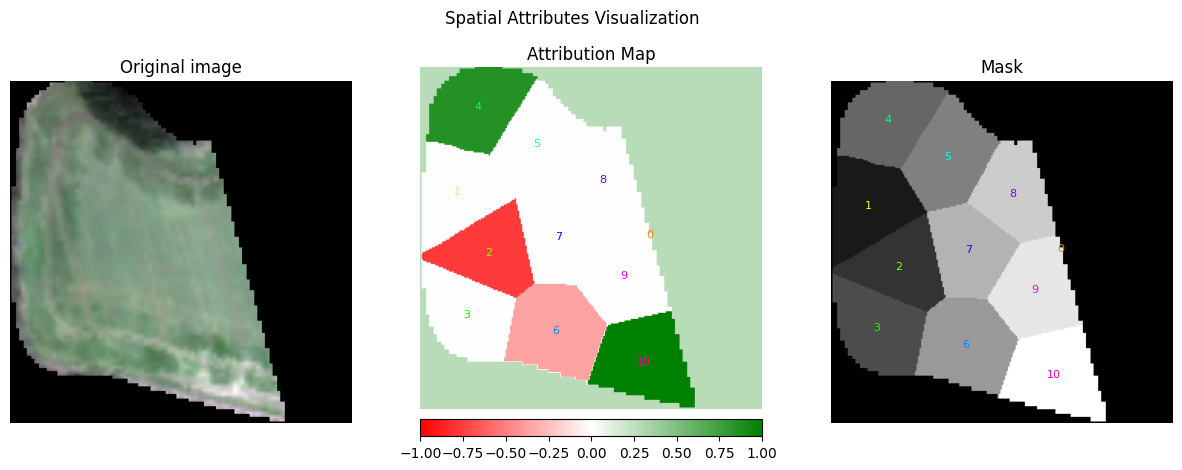

In [94]:
mt.visualize.visualize_spatial_attributes(spatial_attributes)
print(f"R2 metric: {spatial_attributes.score:.4f}")
plt.show()

In our case, the green regions may correspond to areas with a higher concentration of the parameter being tested - here phosporus. 

#### Different segmentation masks

The most semantically meaningful segmentation mask is the one created by slic method. It contains superpixels that are created based on the image structure. The choice of superpixels is very similiar to the choice of a human.

However, we `meteors` also supports creating the patch segmentation mask, but we are planning to increase support for different methods very soon.

##### Patch segmentation

Patch segmentation mask tests the importance of regions shaped as rectangles. It is designed to work well with the ViT architecure, but it gives less semantic meaning.

Let's check the `patch` segmentation mask and see how it affects the attribution maps.

In [17]:
spatial_attributes = lime.get_spatial_attributes(hsi_0, segmentation_mask_patch, target=1, n_samples=10, verbose=True)

Lime attribution: 100%|██████████| 3/3 [00:06<00:00,  2.15s/it]
2024-09-18 11:02:01.651 | DEBUG    | meteors.lime:resolve_inference_device:459 - Device for inference: cpu


R2 metric: 0.5148


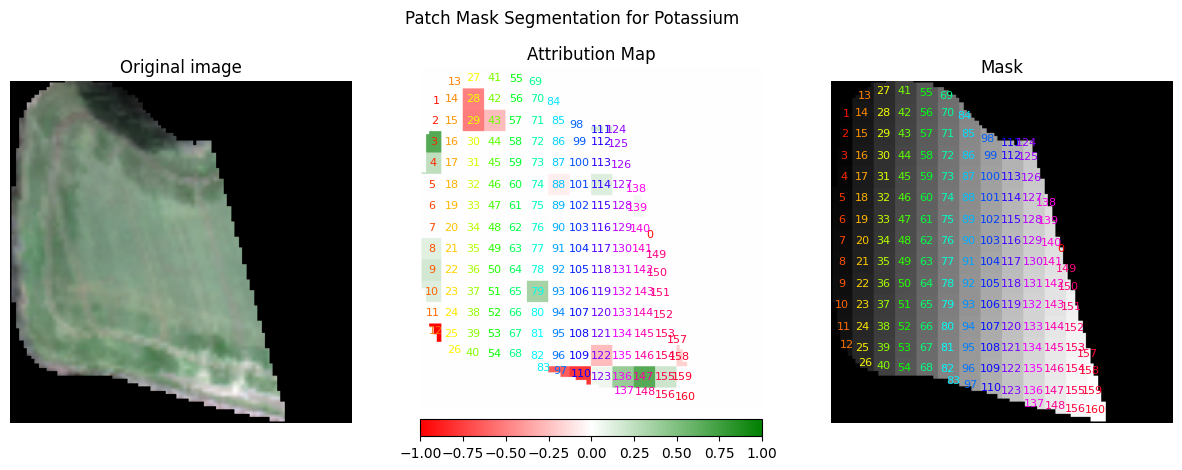

In [22]:
fig, ax = mt.visualize.visualize_spatial_attributes(spatial_attributes)
print(f"R2 metric: {spatial_attributes.score:.4f}")
fig.suptitle("Patch Mask Segmentation for Potassium")
plt.show()

As we can see the Lime explainer focused on different regions of the image.

In [95]:
spatial_attributes = lime.get_spatial_attributes(
    hsi_0, segmentation_mask_patch, target=1, n_samples=100, perturbations_per_eval=10, verbose=True
)

Lime attribution: 100%|██████████| 10/10 [00:51<00:00,  5.10s/it]
2024-09-18 23:01:58.892 | DEBUG    | meteors.lime:resolve_inference_device:459 - Device for inference: cpu


R2 metric: 0.5463


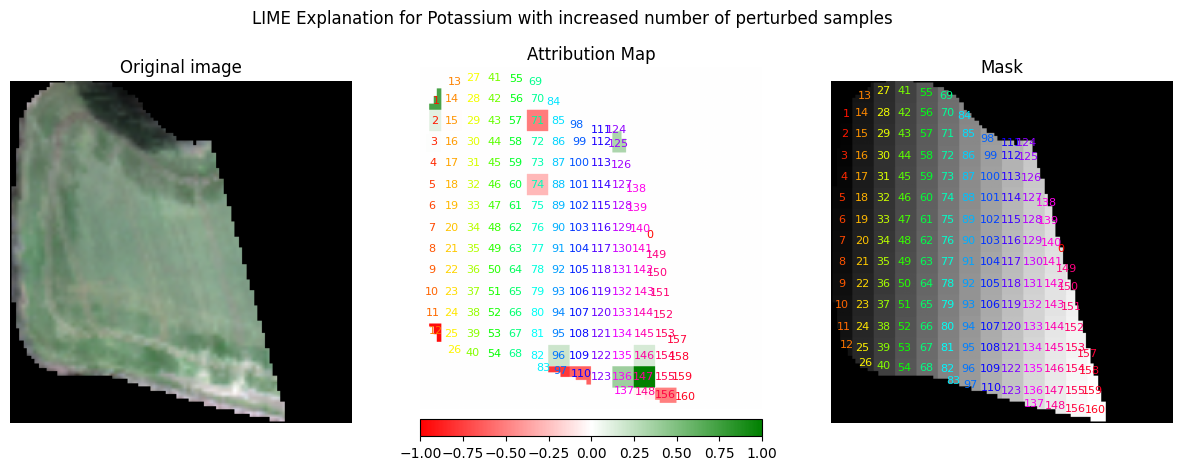

In [96]:
fig, ax = mt.visualize.visualize_spatial_attributes(spatial_attributes)
print(f"R2 metric: {spatial_attributes.score:.4f}")
fig.suptitle("LIME Explanation for Potassium with increased number of perturbed samples")
plt.show()

but again, if we increase the number of samples - copies of the original image with perturbed parts, the explainer again focuses on the part of the image in the lower right corner and marks it as positively correlated with the output.

#### Custom segmentation mask

Additionally, an user might want to create their own segmentation mask, or modify the one created by the package.

Therefore, we can inspect this lower right region more thoroughly by creating a more specific segmentation mask based on the slic one.

In [97]:
thorough_segmentation_mask_slic = segmentation_mask_slic.clone()
thorough_segmentation_mask_slic[(thorough_segmentation_mask_slic != 10) & (thorough_segmentation_mask_slic != 0)] = 1

spatial_attributes = lime.get_spatial_attributes(
    hsi_0, thorough_segmentation_mask_slic, target=1, n_samples=100, perturbations_per_eval=10, verbose=True
)

Lime attribution:   0%|          | 0/10 [00:00<?, ?it/s]

Lime attribution: 100%|██████████| 10/10 [00:49<00:00,  4.98s/it]
2024-09-18 23:03:19.948 | DEBUG    | meteors.lime:resolve_inference_device:459 - Device for inference: cpu


R2 metric: 0.9889


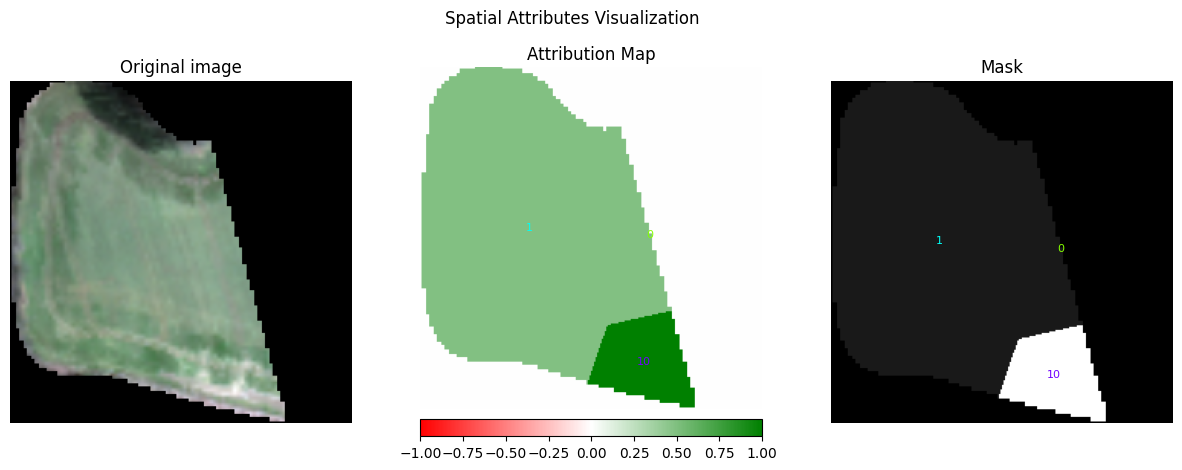

In [98]:
mt.visualize.visualize_spatial_attributes(spatial_attributes)
print(f"R2 metric: {spatial_attributes.score:.4f}")

it is visible, that this superpixel covers area that seems to be the most important region for the model.

##### Mask importance
Using an another custom segmentation mask, we can inspect, if binary mask covers regions that should not be relevant for the model. Now we will use the binary mask used for covering irrelevant regions as a segmentation mask to verify our hypothesis.

Firstly, let's create a another HSI object, this time a plain image without any covering binary mask

In [60]:
image_without_mask = not_masked_image_torch.clone()
hsi_without_mask = mt.HSI(
    image=image_without_mask,  # The preprocessed image tensor, but without the mask
    wavelengths=wavelengths,
    orientation="CWH",
    device=device,
)

2024-09-18 21:44:20.918 | DEBUG    | meteors.hsi:resolve_inference_device:112 - Device for inference: cpu


Now, this image with the segmentation mask that consists of only two classes, we may explore, how each region is important for the model. To do so, we repeat this process for the potassium class.

In [106]:
segmentation_mask_from_binary = binary_mask + 1
spatial_attributes = lime.get_spatial_attributes(
    hsi_without_mask, segmentation_mask_from_binary, target=1, n_samples=10, verbose=True
)

C:\Users\tymot\Documents\praca\pineapple\meteors\src\meteors\lime_base.py:738: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn("Minimum element in feature mask is not 0, shifting indices to" " start at 0.")
Lime attribution: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]
2024-09-18 23:09:04.748 | DEBUG    | meteors.lime:resolve_inference_device:459 - Device for inference: cpu


R2 metric: 0.2594


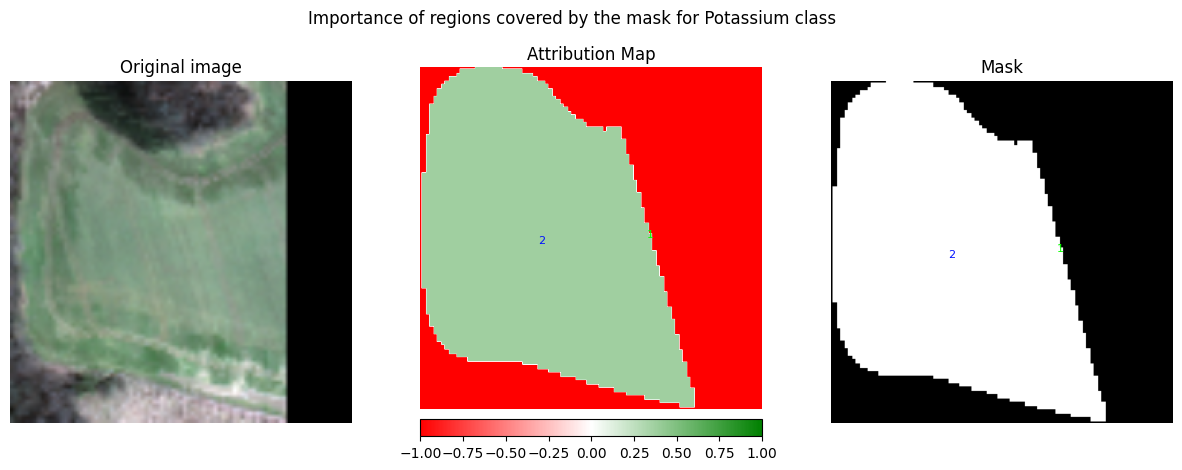

In [107]:
fig, ax = mt.visualize.visualize_spatial_attributes(spatial_attributes)
fig.suptitle("Importance of regions covered by the mask for Potassium class")
print(f"R2 metric: {spatial_attributes.score:.4f}")

as we can see, the model correctly has learned that the relevant information is not covered with the mask. The region that was coovered by default using the mask is strongly negatively correlated with the output, which may suggest that indeed, mask covers some regions that lowers model /predictions.

### Spectral Analysis

The spectral analysis is similar to the spatial analysis, but instead of analyzing the spatial dimension of the hyperspectral images, we analyze the spectral dimension. In the process we group the specific channels of the image into superbands (groups of bands) and investigate importances of such groups. The spectral or band mask is a similar torch tensor or numpy ndarray as the segmentation mask, but instead of grouping regions it groups image channels. In the similar manner it is repeated along the width and height dimensions of the image.


Since this kind of spectral analysis has sense only in hyperspectral imaginery, we paid special attention to this novel feature. As in the case of segmentation mask, user has several options how to create the band mask, to ensure that they had no difficulty using the analysis package and could rather focus on explaining the model. In the current package version user can:
- provide the spectral indices or indexes of the commmonly recognized bands
- specify exactly which wavelengths should compose the band mask
- specify which wavelength indices corresponding to the wavelength list from the explained HSI object should be used

All these band masks can be obtained using one simple method `get_band_mask`, which detailed documentation may also be found in the [reference](https://xai4space.github.io/meteors/latest/reference/#src.meteors.attr.Lime.get_band_mask). Now we will go through these different methods of creating the band mask and create some attributions.

#### Band and indices names
This, definetely the fastest for the user, method provides a quick way to explore importance of some well known superbands. To create the band mask using this approach, all we need to do is to pass a list or a dictionary of the band names:

In [118]:
band_mask, band_names = lime.get_band_mask(hsi_0, ["R", "G", "B"])

2024-09-19 00:33:19.737 | DEBUG    | meteors.lime:get_band_mask:964 - Getting band mask from band names of spectral bands
2024-09-19 00:33:19.737 | DEBUG    | meteors.lime:_get_band_wavelengths_indices_from_band_names:1111 - band_names is a list of segments, creating a dictionary of segments
2024-09-19 00:33:19.738 | DEBUG    | meteors.lime:_create_tensor_band_mask:1411 - Creating a band mask on the device cpu using 3 segments
2024-09-19 00:33:19.739 | WARNING  | meteors.lime:_check_overlapping_segments:1287 - Segments G and B are overlapping on wavelength 510.0299987792969
2024-09-19 00:33:19.740 | WARNING  | meteors.lime:_check_overlapping_segments:1287 - Segments G and B are overlapping on wavelength 513.219970703125
2024-09-19 00:33:19.741 | WARNING  | meteors.lime:_check_overlapping_segments:1287 - Segments G and B are overlapping on wavelength 516.4199829101562
2024-09-19 00:33:19.741 | WARNING  | meteors.lime:_check_overlapping_segments:1287 - Segments G and B are overlapping on

The band names are: {'R': 1, 'G': 2, 'B': 3}


this method outpus a tuple of two variables:
- `band_mask` - a created band mask
- `band_names` - a dictionary containing mapping from provided labels and segment indices

In this case we created a band mask that contains 4 superpixels - one for each of the base colours and another one including all the background.

In [120]:
band_names

{'R': 1, 'G': 2, 'B': 3}

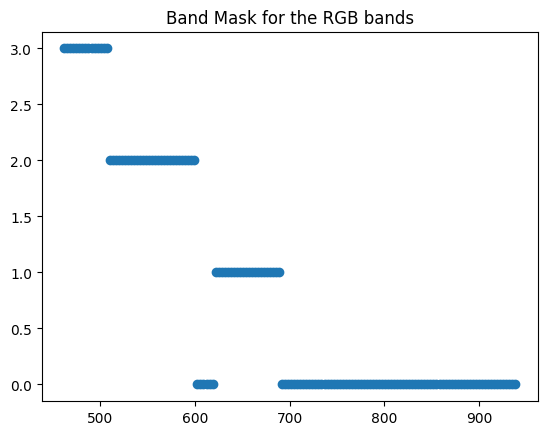

In [127]:
plt.scatter(wavelengths, band_mask.squeeze(1).squeeze(1))

plt.title("Band Mask for the RGB bands")

plt.show()

The plot presents how bands are grouped. The bands with the value 0 creates the additional band group `not_included` which also will be used in the analysis.

Now, we can analyze the hyperspectral image based on the spectral dimension. We will use the same LIME model as in the spatial analysis (initialize with the same parameters), but we will provide the band mask instead of the segmentation mask and also band names.

In [18]:
lime = mt.Lime(
    explainable_model=mt.utils.models.ExplainableModel(model, "regression"),
    interpretable_model=mt.utils.models.SkLearnLasso(alpha=0.001),
)

In [128]:
spectral_attributes = lime.get_spectral_attributes(
    hsi_0,  # HSI data
    band_mask=band_mask,  # Band mask
    target=1,  # class analyzed - K - potassium
    band_names=band_names,  # Band names
    n_samples=10,  # Number of perturbation, the more the better explainer is trained but the analsys is slower
)

2024-09-19 00:38:38.377 | DEBUG    | meteors.lime:get_spectral_attributes:1649 - Band names are provided and will be used. In the future, there should be an option to validate them.
2024-09-19 00:38:49.277 | DEBUG    | meteors.lime:resolve_inference_device:459 - Device for inference: cpu
C:\Users\tymot\Documents\praca\pineapple\meteors\src\meteors\lime.py:181: UserWarning: Band mask contains `0` values which are not covered by the provided band names. Adding 'not_included' to band names.
  warnings.warn(


The spectral attributions are similar to spatial attributes consisting of `hsi`, `mask`, `attributes` and `score` of the linear model.

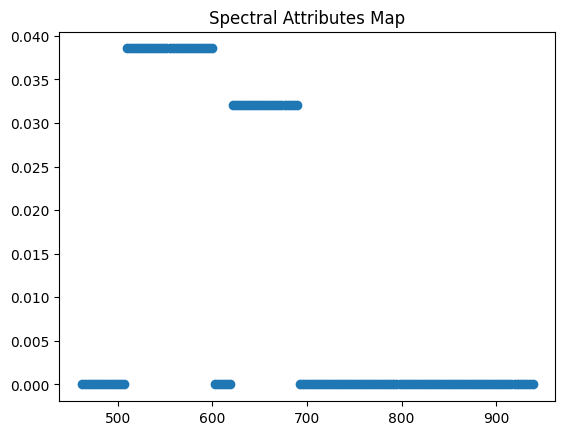

In [147]:
assert len(wavelengths) == spectral_attributes.flattened_attributes.shape[0]
plt.scatter(wavelengths, spectral_attributes.flattened_attributes)
plt.title("Spectral Attributes Map")
plt.show()

But again as with spatial analysis it is much easier to visualize the results using the provided meteors visualization functions.

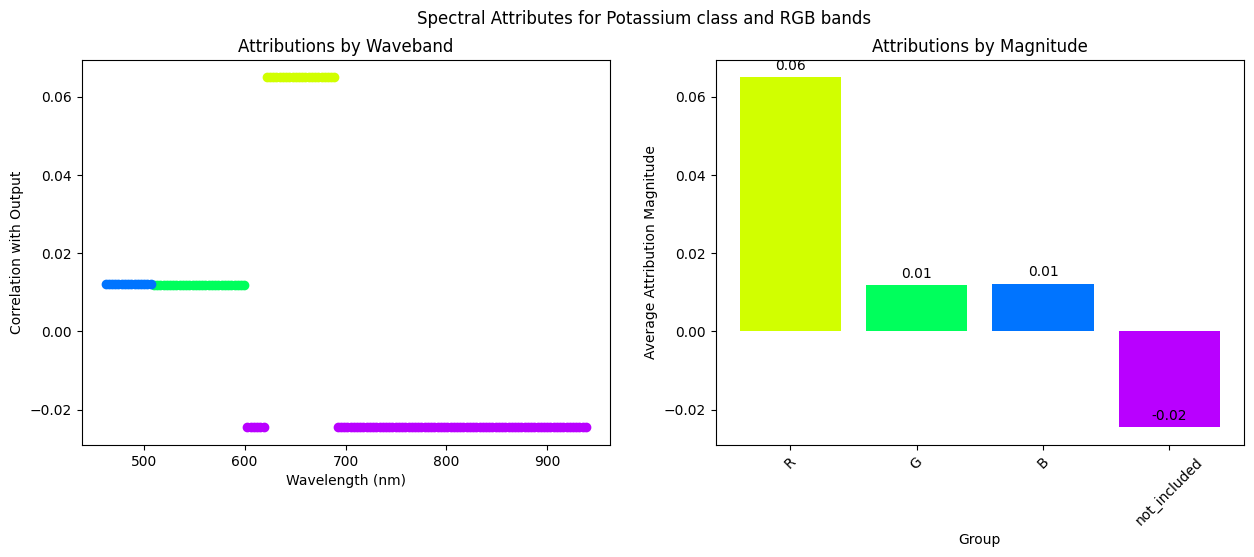

In [132]:
fig, ax = mt.visualize.visualize_spectral_attributes(spectral_attributes, show_not_included=True)
fig.suptitle("Spectral Attributes for Potassium class and RGB bands")
plt.show()

The plot this time consists of two parts. On the left, we have the attribution value per band for the hyperspectral image; on the right, we have the attribution map magnitudes for each superband. On the left, we see similar colors to the right plots marking the same superbands. With the left plot, we are able to see how the bands are important for the model, and on the right, we see how important each superband is.

To validate the model, we have the `score` attribute, which indicates the `R2` metric of how well-trained the surrogate model was.

In [131]:
spectral_attributes.score

0.9599303007125854

All the band names are sourced from the [Awesome Spectral Indices](https://github.com/awesome-spectral-indices/awesome-spectral-indices?tab=readme-ov-file#expressions) repository and handled using the `spyndex` library. Therefore, we can explore all the bands or try out some more exotic combinations using the predefined band indices [here](https://github.com/awesome-spectral-indices/awesome-spectral-indices?tab=readme-ov-file#spectral-indices-by-application-domain) 

We will use now one of the indices taken from the library. # cant do that yet, because of the bugs

In [143]:
band_mask, band_names = lime.get_band_mask(hsi_0, ["R", "G"])

2024-09-19 01:00:59.232 | DEBUG    | meteors.lime:get_band_mask:964 - Getting band mask from band names of spectral bands
2024-09-19 01:00:59.233 | DEBUG    | meteors.lime:_get_band_wavelengths_indices_from_band_names:1111 - band_names is a list of segments, creating a dictionary of segments
2024-09-19 01:00:59.234 | DEBUG    | meteors.lime:_create_tensor_band_mask:1411 - Creating a band mask on the device cpu using 2 segments
2024-09-19 01:00:59.235 | DEBUG    | meteors.lime:_validate_and_create_dict_labels_to_segment_ids:1320 - Using existing mapping from segment labels into segment ids
2024-09-19 01:00:59.235 | DEBUG    | meteors.lime:_validate_and_create_dict_labels_to_segment_ids:1334 - Passed mapping is correct


now, using the same methods as before, we can attribute the new superbands using the LIME explainer and visualize the output

In [144]:
band_names

{'R': 1, 'G': 2}

In [145]:
spectral_attributes = lime.get_spectral_attributes(
    hsi_0,  # HSI data
    band_mask=band_mask,  # Band mask
    target=1,  # class analyzed - K - potassium
    band_names=band_names,  # Band names
    n_samples=10,  # Number of perturbation, the more the better explainer is trained but the analsys is slower
)

2024-09-19 01:01:03.030 | DEBUG    | meteors.lime:get_spectral_attributes:1649 - Band names are provided and will be used. In the future, there should be an option to validate them.
2024-09-19 01:01:08.432 | DEBUG    | meteors.lime:resolve_inference_device:459 - Device for inference: cpu
C:\Users\tymot\Documents\praca\pineapple\meteors\src\meteors\lime.py:181: UserWarning: Band mask contains `0` values which are not covered by the provided band names. Adding 'not_included' to band names.
  warnings.warn(


R2 metric: 0.7713


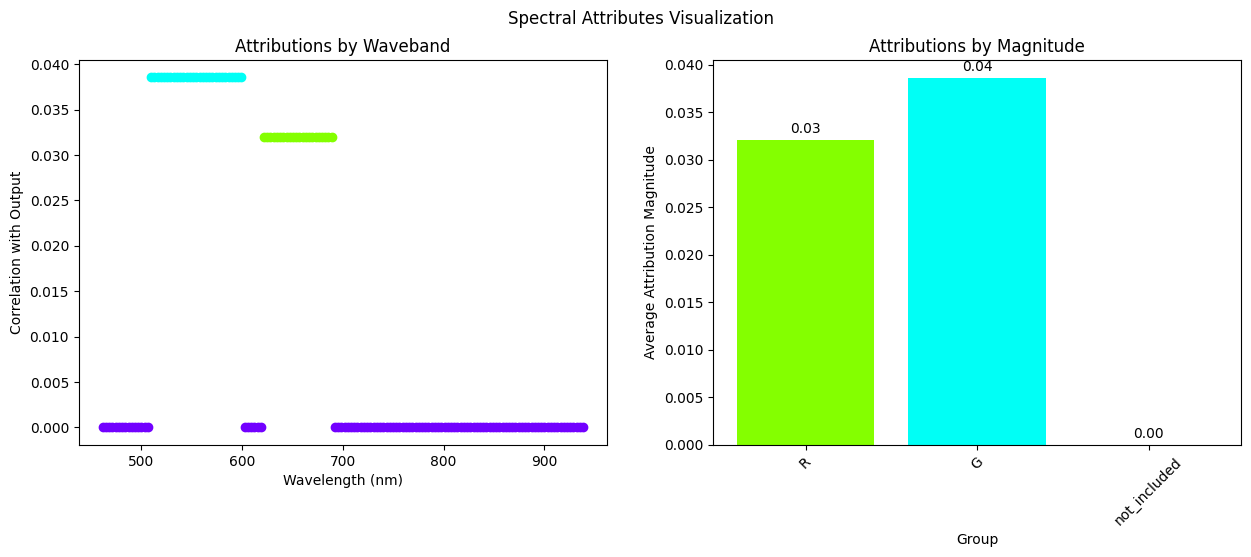

In [146]:
mt.visualize.visualize_spectral_attributes(spectral_attributes, show_not_included=True)
print(f"R2 metric: {spectral_attributes.score:.4f}")
plt.show()

In this way, we may investigate if the model uses the bands that were commonly used for the similar tasks in the literature, which could help us debbuging the model.

#### Wavelengths ranges
In some cases, we do not want to use any well known band combinations. In our team, we had access to knowledge of domain experts who gave us the exact wavelength values that are used to detect potassium, phosphorus, magnessium and pH in the soil. Now we can utilize this knowledge and create our own superbands. 

Now we will try out the values for the potassium. Unfortunately, not all the wavelengths provided are exactly mentioned in our wavelengths list, thus we need to find the closest corresponding indices to the values given by the experts.

In [183]:
potassium_superband_indices = [0, 1, 4, 10, 43, 46, 47]  # supposedly important bands for potassium
# or differently
potassium_superband_wavelengths = [wavelengths[i] for i in potassium_superband_indices]

In [184]:
potassium_superband_wavelengths

[462.08, 465.27, 474.86, 494.04, 599.53, 609.12, 612.32]

In [185]:
type(potassium_superband_indices)

list

In [190]:
band_dict = {"potassium": potassium_superband_indices, "random_superpixel": [i for i in range(20, 30)]}
band_dict

{'potassium': [0, 1, 4, 10, 43, 46, 47],
 'different_superpixel': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]}

In [191]:
band_mask, band_names = lime.get_band_mask(hsi_0, band_indices=band_dict)

2024-09-19 01:25:54.943 | DEBUG    | meteors.lime:get_band_mask:989 - Getting band mask from band groups given by ranges of indices
2024-09-19 01:25:54.944 | DEBUG    | meteors.lime:_create_tensor_band_mask:1411 - Creating a band mask on the device cpu using 2 segments
2024-09-19 01:25:54.945 | DEBUG    | meteors.lime:_validate_and_create_dict_labels_to_segment_ids:1317 - Creating mapping from segment labels into ids


In [193]:
band_names  # the mapping from names to segment labels

{'potassium': 1, 'different_superpixel': 2}

In [196]:
spectral_attributes = lime.get_spectral_attributes(
    hsi_0,
    band_mask=band_mask,
    target=1,
    band_names=band_names,
    n_samples=100,
)

2024-09-19 01:26:52.504 | DEBUG    | meteors.lime:get_spectral_attributes:1649 - Band names are provided and will be used. In the future, there should be an option to validate them.
2024-09-19 01:27:43.282 | DEBUG    | meteors.lime:resolve_inference_device:459 - Device for inference: cpu
C:\Users\tymot\Documents\praca\pineapple\meteors\src\meteors\lime.py:181: UserWarning: Band mask contains `0` values which are not covered by the provided band names. Adding 'not_included' to band names.
  warnings.warn(


R2 metric: 0.3986


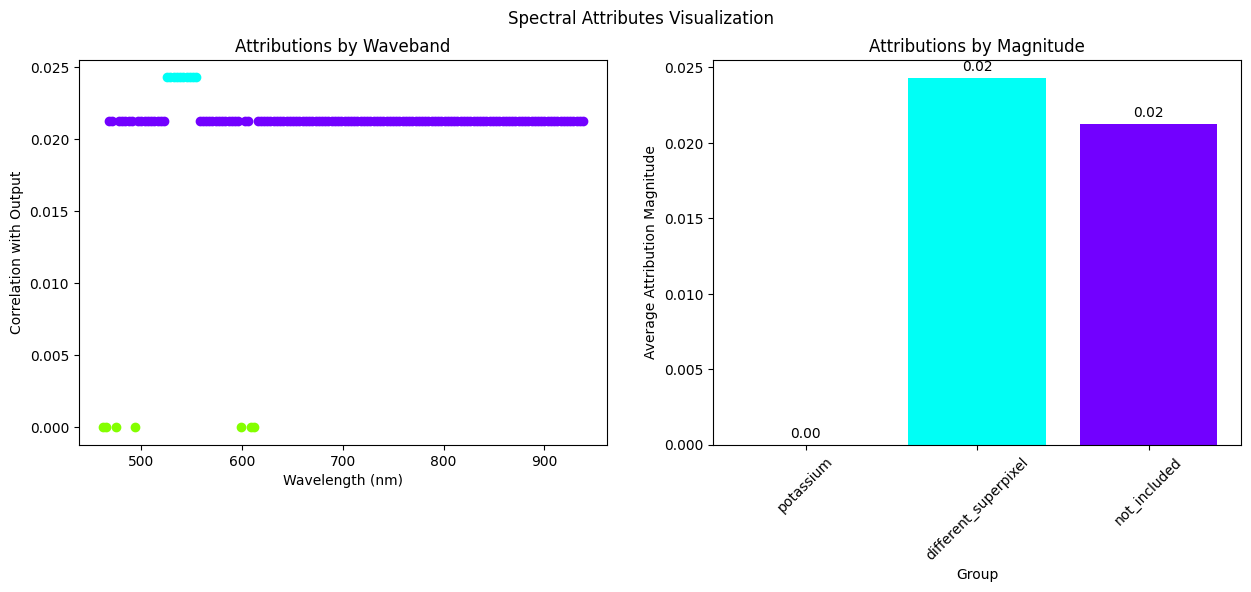

In [197]:
mt.visualize.visualize_spectral_attributes(spectral_attributes, show_not_included=True)
print(f"R2 metric: {spectral_attributes.score:.4f}")
plt.show()

As it turns out, in this case, the bands given us by the experts are not necessarily important for the model. We need to remember, that this analysis is performed for solely one image. Perhaps, this is just one outlier and in different cases model might actually use the specified bands. For such cases, we can utilize the *global explanations* which are attributions aggregeated for multiple input images. 

### Global attributions

An interesting capability unique to spectral analysis is the ability to aggregate results across multiple samples, allowing us to transition from local interpretation to global interpretation. This is usually not possible for spatial analysis, as the images differ significantly when it comes to the covered land, but similar bands usually carry similar information.

To give an idea how to perform such analysis, we need a second sample of the hyperspectral image.

In [210]:
data, mask = load_single_npz_image("data/1.npz")
masked_data = data * mask
masked_data = torch.from_numpy(masked_data.astype(np.float32)).permute(2, 0, 1)
eval_tr = get_eval_transform(224)

image_torch_1 = eval_tr(masked_data)
not_masked_image_torch_1 = eval_tr(torch.from_numpy(data.astype(np.float32)).permute(2, 0, 1))

In [211]:
binary_mask_1 = (image_torch_1 > 0.0).int()

hsi_1 = mt.HSI(
    image=not_masked_image_torch_1, wavelengths=wavelengths, orientation="CWH", binary_mask=binary_mask_1, device=device
)

2024-09-19 01:35:02.336 | DEBUG    | meteors.hsi:resolve_inference_device:112 - Device for inference: cpu


Now, once the image is properly loaded and preprocessed, let's get the attributions for the second sample, using the same band mask as before

In [212]:
spectral_attributes_1 = lime.get_spectral_attributes(
    hsi_1, band_mask=band_mask, target=1, band_names=band_names, n_samples=100, verbose=True
)

2024-09-19 01:35:03.641 | DEBUG    | meteors.lime:get_spectral_attributes:1649 - Band names are provided and will be used. In the future, there should be an option to validate them.
Lime attribution: 100%|██████████| 25/25 [00:50<00:00,  2.04s/it]
2024-09-19 01:35:54.622 | DEBUG    | meteors.lime:resolve_inference_device:459 - Device for inference: cpu
C:\Users\tymot\Documents\praca\pineapple\meteors\src\meteors\lime.py:181: UserWarning: Band mask contains `0` values which are not covered by the provided band names. Adding 'not_included' to band names.
  warnings.warn(


R2 metric: 0.3986


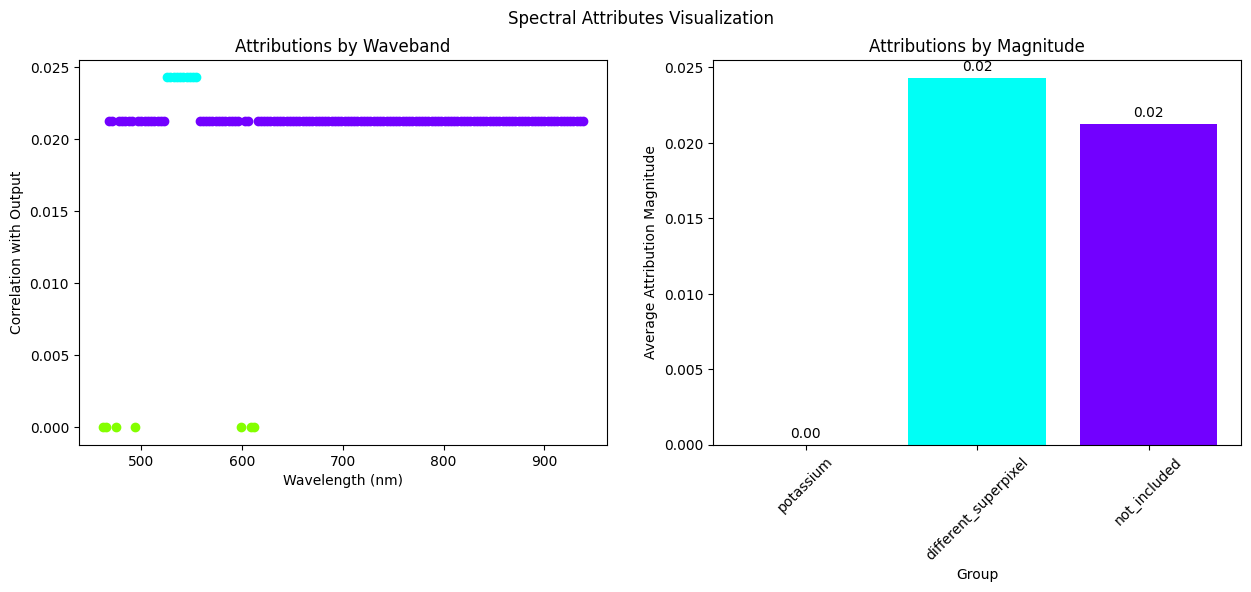

In [213]:
mt.visualize.visualize_spectral_attributes(spectral_attributes, show_not_included=True)
print(f"R2 metric: {spectral_attributes.score:.4f}")
plt.show()

To get the global interpretation we will provide the list of attributions to the meteors visualizer to create the global interpretation visualization.

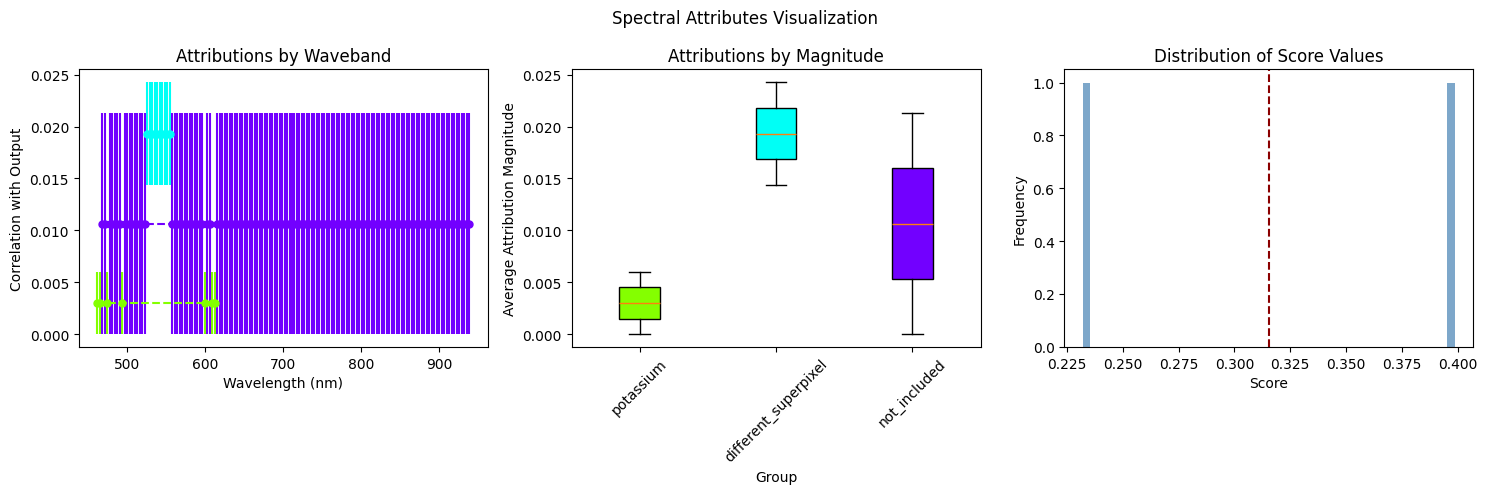

In [214]:
mt.visualize.visualize_spectral_attributes([spectral_attributes, spectral_attributes_1], show_not_included=True)
plt.tight_layout()
plt.show()

As it turns out, the model does not necessarily use the specified bands in the prediction of the potassium class. This is probably insufficient to conclude anything using only attributions from 2 images, especially because the `score` of the explanations was low, but our model suprisingly does not use the expected wavelengths.